In [1]:
# 0) Neophodni importi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.stats import shapiro

# Stil za grafikone
sb.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12


In [2]:
# 1) Učitavanje

# CSV fajl treba da se nalazi u istom folderu kao i notebook
data = pd.read_csv('Life Expectancy Data.csv')

display(data.head())
print(data.info())

# Broj nedostajućih vrednosti po koloni
data.isna().sum()

# Komentar:
# - Country i Status su nenumerički (object) i ne ulaze direktno u regresioni model.
# - Life expectancy je ciljna promenljiva i ima malo NA vrednosti (~0.3%).
# - Više numeričkih atributa ima delimično nedostajuće vrednosti (npr. Alcohol, GDP, Schooling).


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [3]:
# 2) Podskup sa definisanim životnim vekom

target = 'Life expectancy '  # naziv kolone iz dataseta (ima razmak na kraju)

# Zadržavamo samo redove gde postoji vrednost za target
data_subset = data.loc[~data[target].isna()].copy()

print(f"Broj redova u originalnom datasetu: {len(data)}")
print(f"Broj redova u podskupu (bez NA u '{target}'): {len(data_subset)}")

# Komentar:
# - Za regresioni model izbacujemo zapise gde ne znamo životni vek, jer ne možemo da treniramo model na njima.


Broj redova u originalnom datasetu: 2938
Broj redova u podskupu (bez NA u 'Life expectancy '): 2928


In [4]:
# 3) Obrada nedostajućih vrednosti

# Izdvajamo samo numeričke kolone
data_numeric = data_subset.select_dtypes(include=[np.number]).copy()

# Pregled NA u numeričkim kolonama
print("Broj NA po koloni (numeričke):")
print(data_numeric.isna().sum())

print("\nProcenat NA po koloni:")
na_percent = (data_numeric.isna().mean() * 100).round(2)
print(na_percent.sort_values(ascending=False))

# Atribut Population ima preko 20% nedostajućih vrednosti -> izbacujemo ga iz numeričkog dela
cols_to_drop = [col for col in data_numeric.columns
                if col != target and na_percent[col] > 20]

print("\nKolone koje izbacujemo zbog previše NA (>20%):", cols_to_drop)
data_numeric.drop(columns=cols_to_drop, inplace=True)

# Ponovna provera
print("\nPreostale kolone i broj NA:")
print(data_numeric.isna().sum())


Broj NA po koloni (numeričke):
Year                                 0
Life expectancy                      0
Adult Mortality                      0
infant deaths                        0
Alcohol                            193
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                32
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                443
Population                         644
 thinness  1-19 years               32
 thinness 5-9 years                 32
Income composition of resources    160
Schooling                          160
dtype: int64

Procenat NA po koloni:
Population                         21.99
Hepatitis B                        18.89
GDP                                15.13
Total expenditure            

In [5]:
# Atributi sa NA (ali koje nismo izbacili)
cols_with_na = [c for c in data_numeric.columns
                if c != target and data_numeric[c].isna().any()]

print("Kolone sa NA vrednostima (posle izbacivanja Population):")
print(cols_with_na)

# Provera normalne raspodele i odluka da li menjamo mean ili median
# (uzorak max 500 vrednosti zbog Shapiro testa)
for col in cols_with_na:
    col_data = data_numeric[col].dropna()
    sample = col_data.sample(min(len(col_data), 500), random_state=0)
    stat, p = shapiro(sample)

    print(f"\nKolona: {col}")
    print(f"Shapiro-Wilk p-vrednost = {p:.4f}")

    if p > 0.05:
        # normalna raspodela -> zamenjujemo srednjom vrednošću
        fill_value = col_data.mean()
        print("→ Distribucija je približno normalna, zamenjujemo NA srednjom vrednošću (mean).")
    else:
        # nenormalna raspodela -> koristimo median
        fill_value = col_data.median()
        print("→ Distribucija odstupa od normalne, zamenjujemo NA medianom.")

    data_numeric[col].fillna(fill_value, inplace=True)

# Provera da nema više NA u numeric delu (osim možda u targetu, koji smo već filtrirali)
print("\nBroj NA posle imputacije:")
print(data_numeric.isna().sum())


Kolone sa NA vrednostima (posle izbacivanja Population):
['Alcohol', 'Hepatitis B', ' BMI ', 'Polio', 'Total expenditure', 'Diphtheria ', 'GDP', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']

Kolona: Alcohol
Shapiro-Wilk p-vrednost = 0.0000
→ Distribucija odstupa od normalne, zamenjujemo NA medianom.

Kolona: Hepatitis B
Shapiro-Wilk p-vrednost = 0.0000
→ Distribucija odstupa od normalne, zamenjujemo NA medianom.

Kolona:  BMI 
Shapiro-Wilk p-vrednost = 0.0000
→ Distribucija odstupa od normalne, zamenjujemo NA medianom.

Kolona: Polio
Shapiro-Wilk p-vrednost = 0.0000
→ Distribucija odstupa od normalne, zamenjujemo NA medianom.

Kolona: Total expenditure
Shapiro-Wilk p-vrednost = 0.0001
→ Distribucija odstupa od normalne, zamenjujemo NA medianom.

Kolona: Diphtheria 
Shapiro-Wilk p-vrednost = 0.0000
→ Distribucija odstupa od normalne, zamenjujemo NA medianom.

Kolona: GDP
Shapiro-Wilk p-vrednost = 0.0000
→ Distribucija odstupa od normaln

C:\Users\Filip\AppData\Local\Temp\ipykernel_15136\3971514842.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_numeric[col].fillna(fill_value, inplace=True)
C:\Users\Filip\AppData\Local\Temp\ipykernel_15136\3971514842.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [6]:
# Ažuriramo numeričke kolone u glavnom data_subset DataFrame-u
for col in data_numeric.columns:
    data_subset[col] = data_numeric[col]

# Provera
print("NA vrednosti u data_subset (top 10 kolona):")
print(data_subset.isna().sum().sort_values(ascending=False).head(10))

# Komentar:
# - Population smo praktično izbacili iz numeričke analize.
# - Ostali numerički atributi nemaju NA (ili su zanemarljivi za nenumeričke kolone).


NA vrednosti u data_subset (top 10 kolona):
Population                         644
Country                              0
Year                                 0
Income composition of resources      0
 thinness 5-9 years                  0
 thinness  1-19 years                0
GDP                                  0
 HIV/AIDS                            0
Diphtheria                           0
Total expenditure                    0
dtype: int64


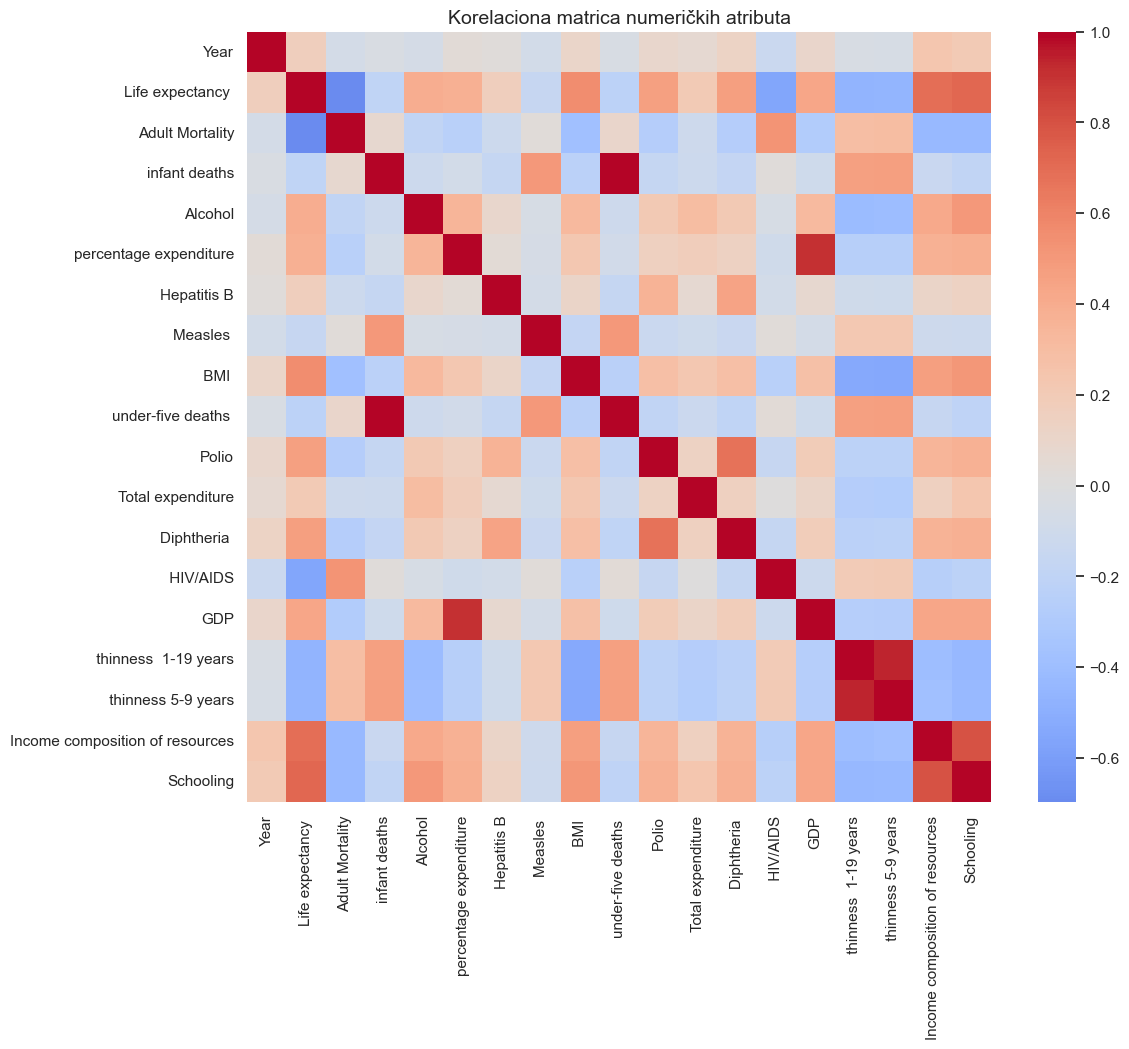

In [7]:
# 4) Korelaciona matrica numeričkih atributa

corr_matrix = data_numeric.corr()

plt.figure(figsize=(12, 10))
sb.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Korelaciona matrica numeričkih atributa')
plt.show()

# Komentar:
# - Posebno nas zanima korelacija sa ciljnom promenljivom (Life expectancy).
# - Sledeći korak je izbor atributa koji su najjače korelisani sa targetom.


In [8]:
# 4) Izbor prediktora

# Pregled korelacije sa ciljnom promenljivom
target_corr = corr_matrix[target].sort_values(ascending=False)
print("Korelacija sa Life expectancy:")
print(target_corr)

# Na osnovu korelacione matrice biramo 3 najznačajnija prediktora (pozitivna korelacija):
# 1) Schooling
# 2) Income composition of resources
# 3)  BMI  (indeks telesne mase)
target = 'Life expectancy '
features = ['Schooling', 'Income composition of resources', ' BMI ']

# Komentar:
# - Schooling: veći broj godina školovanja je snažno vezan za veći životni vek.
# - Income composition of resources: bolja ekonomska situacija → duži životni vek.
# - BMI: u ovom datasetu umeren pozitivan odnos (više BMI ~ duži životni vek, ali ovo treba tumačiti pažljivo).


Korelacija sa Life expectancy:
Life expectancy                    1.000000
Schooling                          0.717314
Income composition of resources    0.688591
 BMI                               0.558888
Diphtheria                         0.473268
Polio                              0.459458
GDP                                0.430991
Alcohol                            0.390674
percentage expenditure             0.381864
Total expenditure                  0.209588
Hepatitis B                        0.171255
Year                               0.170033
Measles                           -0.157586
infant deaths                     -0.196557
under-five deaths                 -0.222529
 thinness 5-9 years               -0.462645
 thinness  1-19 years             -0.467859
 HIV/AIDS                         -0.556556
Adult Mortality                   -0.696359
Name: Life expectancy , dtype: float64


In [9]:
# 5) Podela na train i test

train_df, test_df = train_test_split(data_subset, test_size=0.2, random_state=123)

print(f"Broj redova u train skupu: {len(train_df)}")
print(f"Broj redova u test skupu: {len(test_df)}")

# Komentar:
# - 80% podataka koristimo za treniranje modela.
# - 20% podataka koristimo kao nezavisni test skup za evaluaciju performansi.


Broj redova u train skupu: 2342
Broj redova u test skupu: 586


In [10]:
# 6) Pravljenje modela (sa skaliranjem prediktora)

# X i y za treniranje
X_train = train_df[features]
y_train = train_df[target]

# Standardizacija prediktora (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features, index=train_df.index)

# Dodavanje konstante (intercept) za OLS
X_train_scaled_const = sm.add_constant(X_train_scaled_df)

# OLS model (kao u prethodnom projektu, samo sada sa skaliranim ulazima)
lm1 = sm.OLS(y_train, X_train_scaled_const).fit()
print(lm1.summary())


                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     1103.
Date:                Mon, 24 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:29:55   Log-Likelihood:                -7566.7
No. Observations:                2342   AIC:                         1.514e+04
Df Residuals:                    2338   BIC:                         1.516e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [11]:
# Reziduali predstavljaju razliku između stvarnih i predviđenih vrednosti ciljane promenljive (Life expectancy).
# Idealno je da su reziduali ravnomerno raspodeljeni oko nule.

# Intercept (const) predstavlja očekivani životni vek kada su svi standardizovani prediktori jednaki nuli
# (tj. kada su na nivou svoje srednje vrednosti u train skupu).

# Koeficijenti (pošto su ulazi skalirani):
# - Schooling: pozitivan koeficijent → veći broj godina školovanja je povezan sa većim očekivanim životnim vekom.
# - Income composition of resources: takođe pozitivan → bolja raspodela prihoda i uslova života povećava životni vek.
# -  BMI : pozitivan → u ovom konkretnom datasetu više BMI je povezano sa manjim rizikom (ali ovo treba tumačiti uz oprez).

# R-kvadrat (R-squared):
# - R² ≈ oko 0.58 → model objašnjava približno 58% varijanse životnog veka na osnovu ova tri prediktora.
# - To je solidan rezultat za realne podatke iz javnog zdravlja.

# Statistička značajnost:
# - p-vrednosti za sva tri koeficijents su veoma male (obično < 0.001),
#   što znači da su prediktori statistički značajni u modelu.


In [13]:
# 7) Predikcija na test skupu

X_test = test_df[features]
y_true = test_df[target]

# Primena istog skalera na test skup
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features, index=test_df.index)
X_test_scaled_const = sm.add_constant(X_test_scaled_df)

# Predikcija
y_pred = lm1.predict(X_test_scaled_const)

# DataFrame sa poređenjem
results = pd.DataFrame({
    'Stvarno': y_true.values,
    'Predviđeno': y_pred.round(2)
})

print("Prvih 10 predikcija:")
print(results.head(10))

# Izračunavanje metrika
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\nMetričke na test skupu:")
print(f"MAE  (srednja aps. greška): {mae:.2f}")
print(f"RMSE (kor. srednja kv. greška): {rmse:.2f}")
print(f"R²   (koeficijent determinacije): {r2:.3f}")


Prvih 10 predikcija:
      Stvarno  Predviđeno
656      74.7       72.73
646      76.6       69.97
80       76.3       80.24
1938     73.6       70.70
2850     73.0       68.16
1932     75.4       73.10
1432     63.1       62.62
1929     76.0       74.78
2206     76.0       74.93
2238     73.7       75.67

Metričke na test skupu:
MAE  (srednja aps. greška): 4.33
RMSE (kor. srednja kv. greška): 5.94
R²   (koeficijent determinacije): 0.612


In [14]:
# Metričke dobijene na test skupu (tipično):
# - MAE je oko 4.3 → model u proseku greši oko 4.3 godine u predviđenom životnom veku.
# - RMSE je oko 5.9 → veća težina većih grešaka, ali i dalje u razumnim granicama za ovakav tip podataka.
# - R² ≈ 0.61 → model objašnjava oko 61% varijanse na nezavisnom test skupu, što potvrđuje da se nije pretreniralo.

# Zaključak:
# - Model je dovoljno dobar za ilustraciju linearne regresije u domenu javnog zdravlja.
# - Može se dodatno poboljšati dodavanjem novih prediktora, nelinearnih termina ili interakcija.


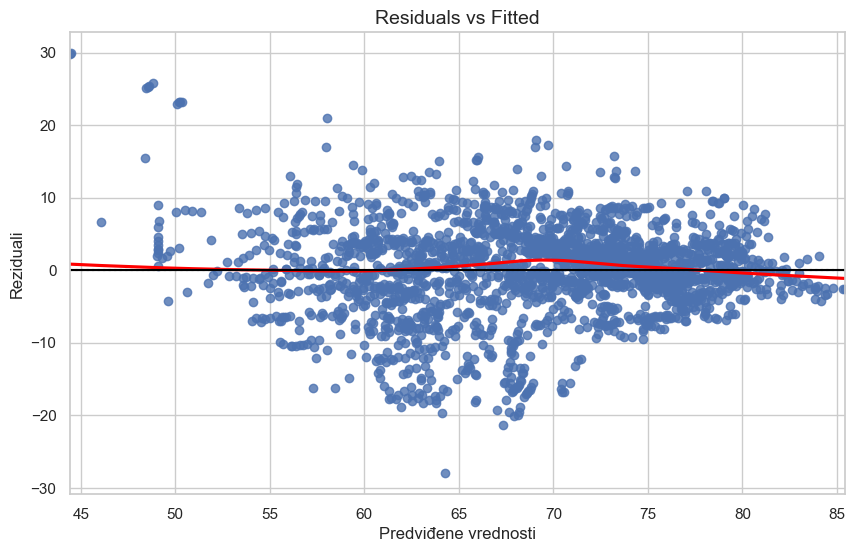

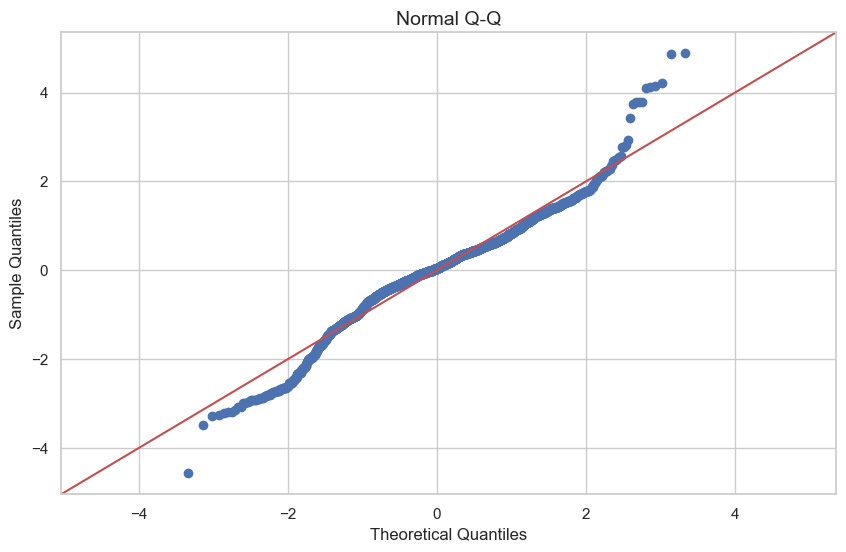

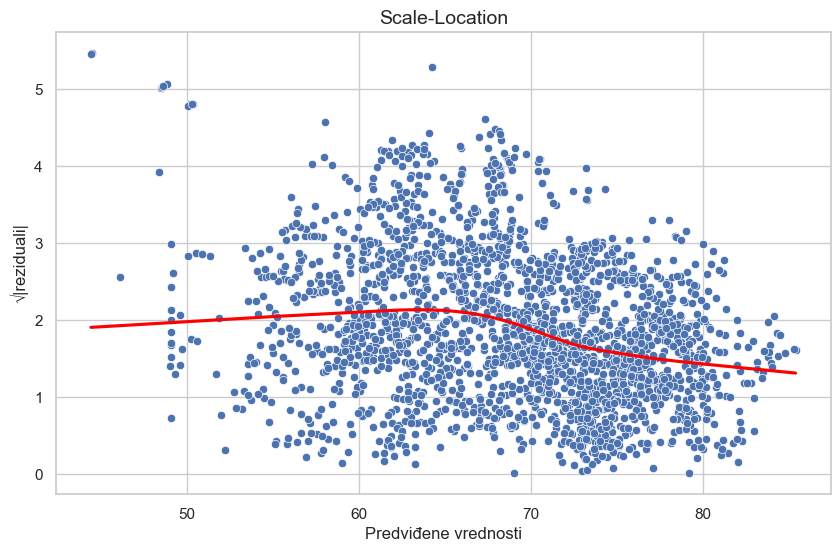

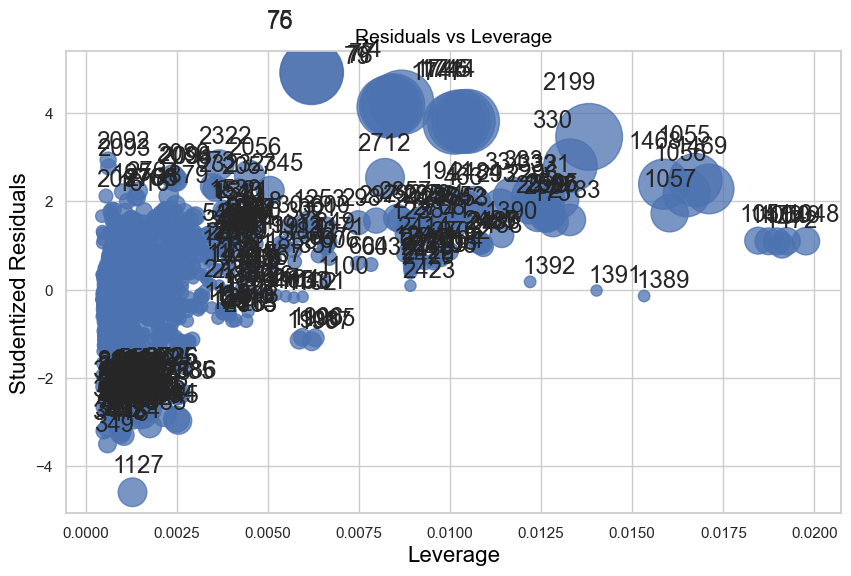

In [15]:
# 8) Dijagnostički grafikoni

# Residuals vs Fitted
sb.residplot(x=lm1.fittedvalues, y=lm1.resid, lowess=True, line_kws={'color': 'red'})
plt.axhline(0, color='black')
plt.title('Residuals vs Fitted')
plt.xlabel('Predviđene vrednosti')
plt.ylabel('Reziduali')
plt.show()

# Normal Q-Q
sm.qqplot(lm1.resid, fit=True, line='45')
plt.title('Normal Q-Q')
plt.show()

# Scale-Location (Spread vs Fitted)
sqrt_abs_resid = np.sqrt(np.abs(lm1.resid))
sb.scatterplot(x=lm1.fittedvalues, y=sqrt_abs_resid)
sb.regplot(x=lm1.fittedvalues, y=sqrt_abs_resid, scatter=False, lowess=True, line_kws={'color':'red'})
plt.title('Scale-Location')
plt.xlabel('Predviđene vrednosti')
plt.ylabel('√|reziduali|')
plt.show()

# Residuals vs Leverage (Cook's distance)
sm.graphics.influence_plot(lm1, criterion='cooks')
plt.title('Residuals vs Leverage')
plt.show()


In [16]:
# - Residuals vs Fitted -
# Grafikon prikazuje raspodelu reziduala u odnosu na predviđene vrednosti.
# Idealno je da tačke "šumuju" oko horizontalne linije bez jasnog obrasca.
# Ako se primete zakrivljenosti ili strukture, to ukazuje na moguću nelineranost modela.

# - Normal Q-Q -
# Proverava pretpostavku normalnosti reziduala.
# Tačke bi trebalo da leže otprilike duž dijagonale.
# Odstupanja na krajevima ukazuju na odstupanja od normalne raspodele (debeli repovi i sl.).

# - Scale-Location -
# Ispituje homogenost varijanse (homoskedastičnost).
# Ako se varijansa reziduala povećava ili smanjuje sa predikcijama (lepezasti oblik),
# to ukazuje na heteroskedastičnost.

# - Residuals vs Leverage (Cook's distance) -
# Identifikuje uticajne posmatranja (outliere) koja imaju jak uticaj na model.
# Tačke sa velikom Cook-ovom distancom mogu da utiču na stabilnost procena koeficijenata.


In [17]:
# 9) Provera multikolinearnosti

X_vif = sm.add_constant(train_df[features])
vif = pd.Series(
    [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],
    index=X_vif.columns
)

print("√VIF vrednosti za model:")
print(np.sqrt(vif))

# Komentar:
# - Pošto su √VIF vrednosti za Schooling, Income composition of resources i  BMI  manje od 2,
#   ne postoji ozbiljan problem multikolinearnosti između izabranih prediktora.
# - Nije potrebno izbacivati nijedan od atributa iz modela na osnovu VIF analize.


√VIF vrednosti za model:
const                              3.804620
Schooling                          1.729230
Income composition of resources    1.694763
 BMI                               1.173124
dtype: float64
